### Abstract

<center>
<p style="line-height:1.4; font-family:Times New Roman; text-align:justify; width: 75%;"" >
<font size="5">
In this paper I present evidence of a causal mechanism existing between local rent control ordinances and the rate of evictions in San Francisco, CA. 
    Using publically available eviction data collected by the City of San Francisco between 2007 and 2017 (n=43,841), along with SF County Assessor records, I use a regression discontinuity design to estimate the average treatment effect of rent control at +1.42% evictions per residential unit per year. Compared to the baseline eviction rate over this same time period, this causal effect represents a nearly 5x increase in the likelihood of an eviction for rent controlled units compared to their non-rent controlled counterparts.
              </font></p></center>

### To Do:

- [ ] inflated \# units (e.g. parkmerced) due to double counting or counting non-residential units
- [x] properties in some assessor roll years and not others
   - **solution**: take record from closest year, only consider evictions >= 2007
- [x] properties with multiple rent control eligibility use codes:
   - **solution**: count how many of these there are, take the max use code
- [ ] zero-unit buildings in new construction
   - **solution**: year_built < 2010, or units > 0
- [ ] properties with multiple year-built's
   - **solution**: take the max year built, which will give a conservative estimate w/r/t rent control
- [x] year-built = 0
   - **solution**: year_built > 1800
- [ ] condo conversion or parcel splits after eviction but before earliest assessor record
   - SRES --> MRES would overcount MRES evictions
   - MRES --> SRES would undercount MRES evictions
   - **solution**: only count evictions after 2007
   - many of these are the "0000 0000 000000000" values in assessor rolls
- [ ] rent controlled properties more likely to be in state of disrepair and therefore require demolition/capital improvements
   - **solution**: fit hedonic and control for stddev above/below predicted value
- [ ] petition applies to multiple units
   - **solution**: use new eviction .csv with unit counts
- [ ] prop 13 and prop values
- [ ] controlling for num units twice??
- [ ] standard error correction for RDD
- [ ] when grouping assessor records by year, if an address doesn't appear in a given year, I need to impute zero evictions for that year! Right now evictions are just matched to the parcel record in the closest year

### Imports

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline

### Load assessor universe

In [2]:
asr_all = pd.read_csv('../data/assessor_2007-2018_clean_w_none_sttyps.csv')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (1,7,10,16,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
asr_all.columns

Index(['BASELOT', 'BASELOTSFX', 'BATHS', 'BEDS', 'BUILTIN', 'CONSTTYPE',
       'DEPTH', 'EXEMPTYPE', 'FBA', 'FRONT', 'KITCHEN', 'LAREA', 'LOTCODE',
       'OWNRPRCNT', 'PROPLOC', 'RECURRSALD', 'REMARKFLA', 'REPRISDATE',
       'ROLLYEAR', 'ROOMS', 'RP1CLACDE', 'RP1EXMVL1', 'RP1EXMVL2', 'RP1FXTVAL',
       'RP1IMPVAL', 'RP1LNDVAL', 'RP1NBRCDE', 'RP1PPTVAL', 'RP1PRCLID',
       'RP1STACDE', 'RP1TRACDE', 'RP1VOLUME', 'SQFT', 'STOREYNO', 'UNITS',
       'YRBLT', 'ZONE', 'asr_yr', 'use_code', 'rc_eligible', 'house_1',
       'house_2', 'street_name', 'street_rest', 'street_type', 'unit_num',
       'bldg_type'],
      dtype='object')

In [7]:
asr = pd.read_csv('../data/asr_grouped_by_yr_w_fips.csv', dtype={'fipscd': str})

In [14]:
asr['any_ev'] = (asr['ev_count'] > 0).astype(int)
asr['any_ev_07'] = (asr['ev_count_post_07'] > 0).astype(int)
asr['pre_1980'] = (asr['year_built_max'] < 1980)
asr['built_1980'] = None
asr.loc[asr['pre_1980'], 'built_1980'] = 'before'
asr.loc[~asr['pre_1980'], 'built_1980'] = 'after'
asr['ev_per_unit'] = asr['ev_count'] / asr['total_units']
asr['ev_per_unit_since_07'] = asr['ev_count_post_07'] / asr['total_units']

In [53]:
asr['ev_count'].sum()

45273

### Load eviction data

In [65]:
ev = pd.read_csv('../data/ev_matched_w_fips.csv')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
ev.shape

(47720, 26)

### Eviction type counts by built year

#### Processing

Retain only evictions since 2007

In [67]:
ev = ev[ev['year'] >= 2007]

In [68]:
ev.shape

(22609, 26)

% evictions matched to assessor records

In [52]:
len(ev[~pd.isnull(ev['asr_index'])]) / len(ev)

0.9487217099748533

In [21]:
ev = ev.merge(asr, left_on='asr_index', right_on='index', suffixes=('_ev', '_asr'))

In [22]:
ev = ev[ev['any_rc_eligibility'] == 1]

In [23]:
ev.loc[pd.isnull(ev['type']), 'type'] = 'unknown'
type_counts = ev.groupby(['built_1980', 'type']).agg(count=('index_ev', 'nunique')).reset_index()
pre_sums = type_counts.groupby('built_1980')['count'].sum()

In [24]:
pre_sums

built_1980
after       204
before    15188
Name: count, dtype: int64

In [25]:
ev.shape

(15392, 53)

In [16]:
type_counts = type_counts.pivot(index='type', columns='built_1980', values='count')

type_counts['pct_after'] = type_counts['after'] / pre_sums['after']
type_counts['pct_before'] = type_counts['before'] / pre_sums['before']

#### 8x rate of OMI's, but this is prob due to structural differences

In [17]:
type_counts.sort_values('pct_before', ascending=False)

built_1980,after,before,pct_after,pct_before
type,,,,
unknown,47.0,5466.0,0.230392,0.359889
Breach of Lease Agreement,76.0,3312.0,0.372549,0.218067
Nuisance,29.0,1767.0,0.142157,0.116342
OMI,3.0,1262.0,0.014706,0.083092
Capital Improvement,NaN,550.0,NaN,0.036213
Non-payment of Rent,11.0,532.0,0.053922,0.035028
Habitual Late Payment of Rent,4.0,431.0,0.019608,0.028378
ELLIS,NaN,357.0,NaN,0.023505
Development Agreement,NaN,233.0,NaN,0.015341


In [18]:
ev['ev_type_cat'] = 'breach of lease'
ev.loc[ev['type'].isin([
    'OMI', 'Capital Improvement', 'ELLIS', 'Condo Conversion', 'Substantial Rehabilitation',
    'Lead Remediation', 'Good Samaritan Tenancy Ends',
    'Development Agreement', 'Demolition']), 'ev_type_cat'] = 'no fault'
ev.loc[ev['type'].isin(['unknown', 'Other']), 'ev_type_cat'] = 'unknown/Other'

In [19]:
cat_counts = ev.groupby(['built_1980', 'ev_type_cat']).agg(count=('index_ev', 'nunique')).reset_index()

In [20]:
cat_counts

,built_1980,ev_type_cat,count
0,after,breach of lease,136
1,after,no fault,3
2,after,unknown/Other,65
3,before,breach of lease,7057
4,before,no fault,2540
5,before,unknown/Other,5591


In [21]:
cat_counts = cat_counts.pivot(index='ev_type_cat', columns='built_1980', values='count')
cat_counts['pct_after'] = cat_counts['after'] / pre_sums['after']
cat_counts['pct_before'] = cat_counts['before'] / pre_sums['before']

#### Eviction Rates by Category and RC Status

In [22]:
cat_counts

built_1980,after,before,pct_after,pct_before
ev_type_cat,,,,
breach of lease,136,7057,0.666667,0.464643
no fault,3,2540,0.014706,0.167237
unknown/Other,65,5591,0.318627,0.368120


### Mean differences

#### Evictions post-2007:

In [23]:
mean_diffs = asr[
        (asr['year_built_max'] < 2007) &
        (asr['year_built_min'] > 0)].groupby(['any_rc_eligibility', 'pre_1980']).agg(
            mean_any_ev=('any_ev_07', 'mean'),
            total_addresses=('index', 'count'),
            total_units=('total_units', 'sum'),
            total_evictions=('ev_count_post_07', 'sum'),
        )

mean_diffs['units_per_address'] = mean_diffs['total_units'] / mean_diffs['total_addresses']
mean_diffs['evictions_per_address'] = mean_diffs['total_evictions'] / mean_diffs['total_addresses']
mean_diffs['evictions_per_unit'] = mean_diffs['total_evictions'] / mean_diffs['total_units']

mean_diffs

mean_any_ev  total_addresses  total_units  \
any_rc_eligibility pre_1980                                              
0.0                False        0.002104            87451       293578   
                   True         0.002969          1192876      1521359   
1.0                False        0.005936            14993       105574   
                   True         0.018945           364791      1751105   

                             total_evictions  units_per_address  \
any_rc_eligibility pre_1980                                       
0.0                False                 266           3.357057   
                   True                 5767           1.275371   
1.0                False                 178           7.041553   
                   True                14895           4.800297   

                             evictions_per_address  evictions_per_unit  
any_rc_eligibility pre_1980                                             
0.0                False                  0.003042            0.000906  
                   True                   0.004835            0.003791  
1.0                False                  0.011872            0.001686  
                   True                   0.040832            0.008506

#### All Evictions

In [24]:
mean_diffs = asr[
        (asr['year_built_max'] < 2007) &
        (asr['year_built_min'] > 0)].groupby(['any_rc_eligibility', 'pre_1980']).agg(
            mean_any_ev=('any_ev_07', 'mean'),
            total_addresses=('index', 'count'),
            total_units=('total_units', 'sum'),
            total_evictions=('ev_count', 'sum'),
        )

mean_diffs['units_per_address'] = mean_diffs['total_units'] / mean_diffs['total_addresses']
mean_diffs['evictions_per_address'] = mean_diffs['total_evictions'] / mean_diffs['total_addresses']
mean_diffs['evictions_per_unit'] = mean_diffs['total_evictions'] / mean_diffs['total_units']

mean_diffs

mean_any_ev  total_addresses  total_units  \
any_rc_eligibility pre_1980                                              
0.0                False        0.002104            87451       293578   
                   True         0.002969          1192876      1521359   
1.0                False        0.005936            14993       105574   
                   True         0.018945           364791      1751105   

                             total_evictions  units_per_address  \
any_rc_eligibility pre_1980                                       
0.0                False                 558           3.357057   
                   True                14103           1.275371   
1.0                False                 385           7.041553   
                   True                29132           4.800297   

                             evictions_per_address  evictions_per_unit  
any_rc_eligibility pre_1980                                             
0.0                False                  0.006381            0.001901  
                   True                   0.011823            0.009270  
1.0                False                  0.025679            0.003647  
                   True                   0.079859            0.016636

### Plots

#### Processing

In [26]:
rc_pop = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1500) &
    (asr['year_built_max'] < 2500) & (asr['total_units'] > 0)]

In [27]:
rc_pop.shape

(377653, 27)

In [26]:
yr_vs_ev = rc_pop.groupby('year_built_max').agg({
    'ev_per_unit':'mean',
    'ev_per_unit_since_07':'mean'
}).reset_index()

yr_vs_ev1 = yr_vs_ev[(yr_vs_ev['year_built_max'] < 1980) &
                     (yr_vs_ev['year_built_max'] >= 1953)]
yr_vs_ev2 = yr_vs_ev[(yr_vs_ev['year_built_max'] >= 1980) &
                     (yr_vs_ev['year_built_max'] <= 2007)]

#### Viz

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.3, 0.8, 'rent control \nbuilt-year threshold')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/events.py:74: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
  func(*args, **kwargs)
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: 'frac' option in 'arrowprops' is no longer supported; use 'headlength' to set the head length in points.
  fig.canvas.print_figure(bytes_io, **kw)


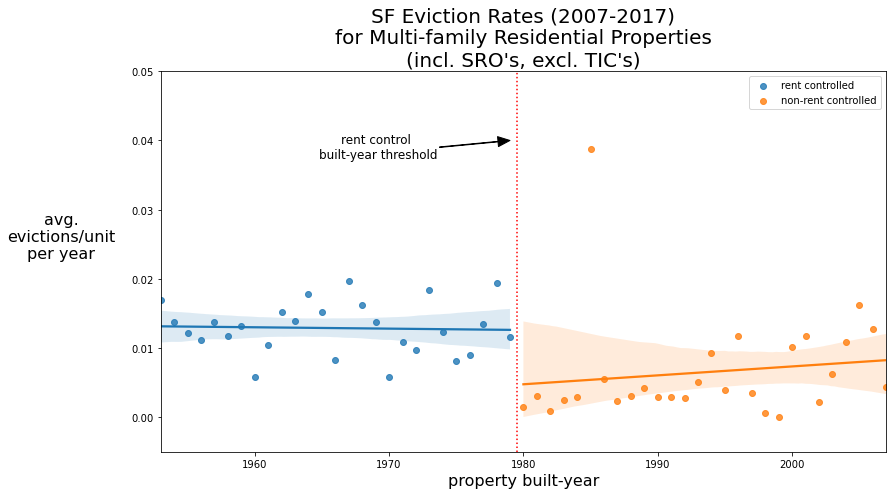

In [27]:
fig, ax = plt.subplots(figsize=(13,7))
sns.regplot('year_built_max', 'ev_per_unit_since_07', yr_vs_ev1, ax=ax, truncate=True, label='rent controlled')
sns.regplot('year_built_max', 'ev_per_unit_since_07', yr_vs_ev2, ax=ax, truncate=True, label='non-rent controlled')
ax.axvline(1979.5, ls=':', c='r')
ax.legend()
_ = ax.set_xlabel("property built-year", fontsize=16)
_ = ax.set_ylabel("avg.\nevictions/unit\nper year", fontsize=16, rotation=0, labelpad=70)
_ = ax.set_title("SF Eviction Rates (2007-2017)\nfor Multi-family Residential Properties\n"
                 "(incl. SRO's, excl. TIC's)", fontsize=20)
ax.set_ylim((-0.005, 0.05))
ax.annotate('rent control \nbuilt-year threshold', xy=(1979, 0.04),  xycoords='data',
            xytext=(0.3, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',frac=0.05, width=0.5, headwidth=10),
            horizontalalignment='center', verticalalignment='center', fontsize=12
            )

### Fit Hedonic regression

In [71]:
asr_all = pd.read_csv('../data/assessor_2007-2018_clean_w_none_sttyps_fips.csv')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,8,11,17,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
asr_all['total_value'] = asr_all['RP1LNDVAL'] + asr_all['RP1IMPVAL']

In [73]:
asr_all.loc[pd.isnull(asr_all['RP1NBRCDE']), 'RP1NBRCDE'] = 'unknown'

In [74]:
asr_grouped_by_yr = asr_all.groupby(['asr_yr', 'house_1', 'house_2', 'street_name', 'street_type']).agg(
    total_units=('UNITS', 'sum'),
    diff_unit_counts=('UNITS', 'nunique'),
    min_units=('UNITS', 'min'),
    diff_bldg_types=('bldg_type', 'nunique'),
    bldg_type_min=('bldg_type', 'min'),
    bldg_type_max=('bldg_type', 'max'),
    diff_rc_eligibility=('rc_eligible', 'nunique'),
    any_rc_eligibility=('rc_eligible', 'max'),
    diff_years_built=('YRBLT', 'nunique'),
    year_built_min=('YRBLT', 'min'),
    year_built_max=('YRBLT', 'max'),
    total_value=('total_value', 'sum'),
    total_beds=('BEDS', 'sum'),
    total_baths=('BATHS', 'sum'),
    mean_stories=('STOREYNO', 'mean'),
    total_sqft=('SQFT', 'sum'),
    nbd=('RP1NBRCDE', pd.Series.mode),
    total_rooms=('ROOMS', 'sum'),
    total_area=('LAREA', 'sum')
    ).reset_index()

In [75]:
asr_grouped_by_yr['nbd'] = asr_grouped_by_yr['nbd'].apply(lambda x: list(x)[0] if type(x) == np.ndarray else x)

In [76]:
asr_grouped_by_yr['yr_built_since_1900'] = asr_grouped_by_yr['year_built_max'] - 1900

In [77]:
df_hed = asr_grouped_by_yr[
    (asr_grouped_by_yr['any_rc_eligibility'] == 1) &
    (asr_grouped_by_yr['total_units'] > 0) & 
    (asr_grouped_by_yr['year_built_max'] >= 1950) &
    (asr_grouped_by_yr['year_built_max'] <= 2010) &
    (asr_grouped_by_yr['total_sqft'] > 0) &
#     (asr_grouped_by_yr['total_beds'] > 0) 
    (asr_grouped_by_yr['total_baths'] > 0) & 
    (asr_grouped_by_yr['total_rooms'] > 0) &
    (asr_grouped_by_yr['mean_stories'] > 0) &
    (asr_grouped_by_yr['total_area'] > 0)
]

In [78]:
hedonic = smf.ols(
    'total_value ~ total_sqft + np.log1p(total_beds) + np.log1p(total_baths) + np.log1p(total_units) + mean_stories + total_area + '
    'total_rooms + yr_built_since_1900 + C(asr_yr) + nbd', data=df_hed
).fit()

In [79]:
df_hed['hedonic_resid'] = hedonic.resid

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
print(hedonic.summary())

                            OLS Regression Results                            
Dep. Variable:            total_value   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     6721.
Date:                Fri, 13 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:42:14   Log-Likelihood:            -9.8665e+05
No. Observations:               61479   AIC:                         1.973e+06
Df Residuals:                   61388   BIC:                         1.974e+06
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -1.15e+

### Merge Census Data

In [40]:
census_df = pd.read_csv('../data/census_tract_acs_data.csv', dtype={'tract_id': str})

In [41]:
census_df.head()

,Unnamed: 0,median_hh_income,total_pop_race,white_only_pop,black_only_pop,multiracial_pop,total_hisp_pop,hispanic_pop,total_pop_tenure,total_renter_pop,...,renter_movein_1990_1999,renter_movein_1980_1989,renter_movein_1970_1979,renter_movein_1969_earlier,median_movein_yr_owners,median_movein_yr_renters,state,county,tract,tract_id
0,0,54798.0,3741.0,1974.0,58.0,300.0,3741.0,385.0,3726.0,3209.0,...,208.0,131.0,41.0,0.0,2003.0,2006.0,6,75,10100,06075010100
1,1,108557.0,4028.0,3416.0,19.0,228.0,4028.0,209.0,3991.0,2603.0,...,101.0,11.0,113.0,47.0,1998.0,2006.0,6,75,10200,06075010200
2,2,91458.0,4729.0,2730.0,0.0,46.0,4729.0,344.0,4710.0,3590.0,...,146.0,96.0,95.0,45.0,1993.0,2007.0,6,75,10300,06075010300
3,3,86847.0,5103.0,3097.0,1.0,329.0,5103.0,470.0,5005.0,3946.0,...,127.0,84.0,100.0,14.0,1995.0,2007.0,6,75,10400,06075010400
4,4,115233.0,2592.0,1765.0,40.0,135.0,2592.0,204.0,2558.0,1897.0,...,80.0,99.0,47.0,59.0,2001.0,2005.0,6,75,10500,06075010500


In [47]:
asr['tract_id'] = asr['fipscd'].astype(str).str.zfill(15).str[:11]

In [51]:
asr = pd.merge(asr, census_df, on='tract_id', how='left')

In [58]:
dropped_parcels = len(asr[pd.isnull(asr['median_hh_income'])])
print('Dropped {0} parcels ({1}%) merging on tract-level census data'.format(
    dropped_parcels, np.round(dropped_parcels/len(asr)*100, 2)))

Dropped 334 parcels (0.02%) merging on tract-level census data


### Fitting the sharp RD

Control variables to add:
- rent burden?
- stddev prop value

In [31]:
bandwidth = 27


In [32]:
df = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1980 - bandwidth) &
    (asr['year_built_max'] < 1980 + bandwidth) & (asr['total_units'] > 0)]

In [33]:
df.shape

(59810, 27)

In [70]:
asr.loc[asr['any_rc_eligibility'] == 1,'ev_count_post_07'].sum()

15392

In [38]:
asr[asr['total_units'] > 0].shape

(1576233, 27)

In [40]:
df['ev_count_post_07'].sum()

2527

In [43]:
df.shape

(59810, 27)

In [61]:
df['rent_control'] = False
df.loc[df['pre_1980'] == True, 'rent_control'] = True
df['year_built_centered'] = df['year_built_max'] - 1980


/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [62]:
df.groupby('pre_1980').agg(
            mean_any_ev=('any_ev', 'mean'),
            total_addresses=('index', 'count'),
            total_units=('total_units', 'sum'),
            total_evictions=('ev_count', 'sum'),
            ev_per_unit=('ev_per_unit', 'mean')
)

,mean_any_ev,total_addresses,total_units,total_evictions,ev_per_unit
pre_1980,,,,,
False,0.014195,14723,109899,377,0.010078
True,0.040810,45087,363510,4190,0.021510


In [81]:
df = pd.merge(
    df,
    df_hed[[
        'asr_yr', 'house_1', 'house_2', 'street_name', 'street_type', 'total_rooms',
        'total_value', 'total_area', 'total_sqft', 'nbd', 'total_baths', 'hedonic_resid']],
    on=['asr_yr', 'house_1', 'house_2', 'street_name', 'street_type'])

### Summary of Models

\begin{array}{rr}
 &(1) & (2) & (3) & (4) \\ \hline 
\text{rent control} & 0.0098^{***} & 0.0166^{*} & 0.0143^{***} & 0.0142^{***}   \\
 & (0.002) &  (0.088) & (< 0.001) & (< 0.001) \\ \hline
\text{Property Characteristics} & N & Y & Y & Y \\
\text{Census Tract Demographics} & N & N & Y & Y \\
\text{Neighborhood Fixed Effects} & N & N & N & Y \\ \hline
R^2 & < 0.001 & 0.008 & 0.007 & 0.009
\end{array}

### Model 1: Standard RDD (No Additional Covariates)

In [88]:
rd = smf.ols(
    "ev_per_unit_since_07 ~ rent_control + year_built_centered*rent_control",
    data=df)

In [89]:
fitted = rd.fit()

In [90]:
print(fitted.summary())

                             OLS Regression Results                             
Dep. Variable:     ev_per_unit_since_07   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     8.381
Date:                  Fri, 13 Nov 2020   Prob (F-statistic):           1.45e-05
Time:                          12:58:33   Log-Likelihood:                 22402.
No. Observations:                 54975   AIC:                        -4.480e+04
Df Residuals:                     54971   BIC:                        -4.476e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### Model 2: Standard RDD + Property Characteristics

todo: divide price/sqft before formula

In [ ]:
ev_count_post_07

In [128]:
rd5 = smf.ols("ev_count_post_07 ~ rent_control + year_built_centered*rent_control + np.log1p(total_units)", data=df)
fitted5 = rd5.fit()
print(fitted5.summary())

                            OLS Regression Results                            
Dep. Variable:       ev_count_post_07   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     106.8
Date:                Fri, 13 Nov 2020   Prob (F-statistic):           8.53e-91
Time:                        14:54:31   Log-Likelihood:                -39130.
No. Observations:               54975   AIC:                         7.827e+04
Df Residuals:                   54970   BIC:                         7.831e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [123]:
rd2 = smf.ols(
    "ev_per_unit_since_07 ~ rent_control + year_built_centered*rent_control + "
    "np.log1p(total_value):np.log(total_sqft) + np.log(total_units)",
    data=df)

In [124]:
fitted2 = rd2.fit()
print(fitted2.summary())

                             OLS Regression Results                             
Dep. Variable:     ev_per_unit_since_07   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     67.40
Date:                  Fri, 13 Nov 2020   Prob (F-statistic):           1.81e-70
Time:                          14:38:31   Log-Likelihood:                 22557.
No. Observations:                 54975   AIC:                        -4.510e+04
Df Residuals:                     54969   BIC:                        -4.505e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### Model 3: Standard RDD + Property Characteristics + Census Tract Attributes

In [106]:
df['pct_non_white'] = 1 - (df['white_only_pop'] / df['total_pop_race'])
df['pct_occ_units_rental'] = df['total_rental_tenure'] / df['total_occupied_units']
df['pct_renter_pop'] = df['total_renter_pop'] / df['total_pop_tenure']
df['pct_rentals_pre2000_movein'] = (
    df['total_rental_tenure'] - df['renter_movein_2005_later'] - df['renter_movein_2000_2004']) / (
    df['total_rental_tenure'])
df['pct_renter_same_house_last_yr'] = df['renter_non_mover'] / df['total_renter_pop']

In [118]:
rd3 = smf.ols(
    "ev_per_unit_since_07 ~ rent_control + year_built_centered*rent_control + "
    "np.log1p(total_value):np.log(total_sqft) + np.log(total_units) + "
    "np.log1p(median_hh_income) + "
    "pct_non_white + "
    "pct_occ_units_rental + "
    "pct_rentals_pre2000_movein",
    data=df)

In [119]:
fitted3 = rd3.fit()
print(fitted3.summary())

                             OLS Regression Results                             
Dep. Variable:     ev_per_unit_since_07   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     40.12
Date:                  Fri, 13 Nov 2020   Prob (F-statistic):           4.85e-72
Time:                          13:35:57   Log-Likelihood:                 22569.
No. Observations:                 54975   AIC:                        -4.512e+04
Df Residuals:                     54965   BIC:                        -4.503e+04
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### Model 4: Standard RDD + Property Characteristics + Census Tract Attributes + Neighborhood Fixed Effects

In [120]:
rd4 = smf.ols(
    "ev_per_unit_since_07 ~ rent_control + year_built_centered*rent_control + "
    "np.log1p(total_value):np.log(total_sqft) + np.log(total_units) + "
    "np.log1p(median_hh_income) + "
    "pct_occ_units_rental + "
    "nbd",
    data=df)

In [122]:
df['nbd'].nunique()

72

In [121]:
fitted4 = rd4.fit()
print(fitted4.summary())

                             OLS Regression Results                             
Dep. Variable:     ev_per_unit_since_07   R-squared:                       0.009
Model:                              OLS   Adj. R-squared:                  0.007
Method:                   Least Squares   F-statistic:                     6.137
Date:                  Fri, 13 Nov 2020   Prob (F-statistic):           1.38e-58
Time:                          13:39:28   Log-Likelihood:                 22628.
No. Observations:                 54975   AIC:                        -4.510e+04
Df Residuals:                     54896   BIC:                        -4.439e+04
Df Model:                            78                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### Potential evictions

In [27]:
units_by_yr = asr[
    (asr['any_rc_eligibility'] == 1) &
    (asr['year_built_max'] > 1900) &
    (asr['year_built_max'] < 2100)].groupby('year_built_max').agg({'total_units': 'sum'}).reset_index()

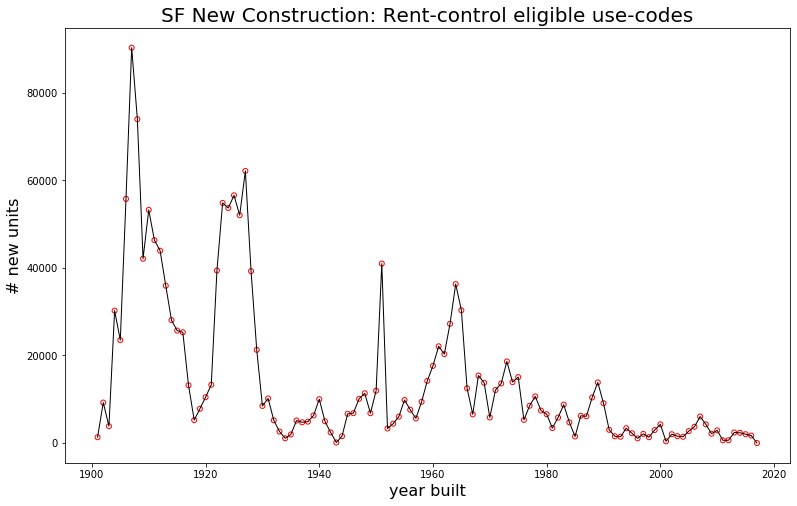

In [28]:
fig, ax = plt.subplots(figsize=(13,8))
ax.scatter(units_by_yr['year_built_max'], units_by_yr['total_units'], s=25, facecolors='none', edgecolors='r')
ax.plot(units_by_yr['year_built_max'], units_by_yr['total_units'], lw=1, c='k', )

_ = ax.set_xlabel("year built", fontsize=16)
_ = ax.set_ylabel("# new units", fontsize=16)
_ = ax.set_title("SF New Construction: Rent-control eligible use-codes", fontsize=20)

In [202]:
rc_pop = asr[(asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1979)]
rc_pop = rc_pop.groupby('year_built_max').agg({'total_units': 'sum'})
rc_pop.index.name = "new rent control year-built cutoff"
rc_pop['cumulative_units'] = rc_pop['total_units'].cumsum()
rc_pop['potential_evictions'] = rc_pop['cumulative_units'] * fitted.params[1]
rc_pop['pct_growth'] = rc_pop['potential_evictions'] / ev_per_year

In [203]:
rc_pop

,total_units,cumulative_units,potential_evictions,pct_growth
new rent control year-built cutoff,,,,
1980,6609,6609,75.078230,0.036528
1981,3442,10051,114.179345,0.055552
1982,5821,15872,180.305897,0.087725
1983,8781,24653,280.058044,0.136257
1984,4738,29391,333.881717,0.162444
1985,1523,30914,351.182995,0.170862
1986,6233,37147,421.989866,0.205312
1987,6134,43281,491.672097,0.239214
1988,10418,53699,610.020562,0.296794


### RDD package

In [7]:
import rdd